# TMS Stimulation

In [1]:
import numpy as np
from tvb.simulator.lab import * 
from mpl_toolkits.mplot3d import Axes3D
from time import time as zeit

label_font = 16
title_font = 24
legend_font = 12

%pylab nbagg
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
from simulation import *
from tms_coil import *
from visualise import *
from stimulus import *

### Define all models

In [3]:
# TVB
neuron_model, heunint, default_cortex, white_matter, white_matter_coupling = get_brain_models()

WARNING  File 'hemispheres' not found in ZIP.


Index numbers of coil positions
0 	 Occipital
1 	 Occipital-Right
2 	 Right
3 	 Frontal-Right
4 	 Frontal
5 	 Frontal-Left
6 	 Left
7 	 Occipital-Left
8 	 Occipital-Cranial-Central
9 	 Cranial
10 	 Frontal-Cranial-Central
11 	 Frontal-Cranial-Right
12 	 Cranial-Right
13 	 Occipital-Cranial-Right
14 	 Occipital-Cranial-Left
15 	 Cranial-Left
16 	 Frontal-Cranial-Left


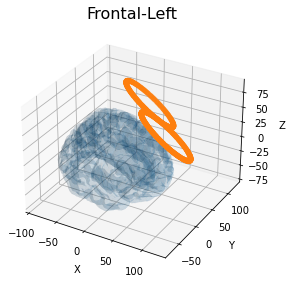

Stimulus distribution at chosen coil position: Frontal-Cranial-Left

Region index    Region label    Stimulus weighting
63              lPMCDL          0.23350613806714346
45              lFEF            0.228451942426088
55              lPFCCL          0.20781878411794066
56              lPFCDL          0.1898217691138802
50              lM1             0.15153664196230657
64              lPMCM           0.12665799092285102
65              lPMCVL          0.12160624009388328
66              lS1             0.11956446299571014
26              rPMCM           0.11164318477799874
57              lPFCDM          0.11106427013961766
18              rPFCDL          0.1096782569234601
61              lPFCVL          0.10854826509262985
41              lCCA            0.10277122926920355
25              rPMCDL          0.09784678697036187
3               rCCA            0.0965410726062197
51              lPCI            0.08980464773767678
19              rPFCDM          0.08968294164970554
6

In [4]:
# Choose TMS coil from "fig8" and "circular"
fig8_coil = TMS_coil(type="fig8")
coil, coil_pts, xs, ys = fig8_coil.get_tms_coil()
plot_coil_shape(xs, ys, "Fig 8")

# Choose coil position from list
ind = 16
field_scale = 1e5
weighting = fig8_coil.get_electric_field_strength(white_matter.centres, ind) * field_scale

plot_coil_on_cortical_surface(coil, ind, default_cortex, title='Frontal-Left')
fig8_coil.get_stimulus_distribution(weighting, white_matter.region_labels, ind)

### Define stimulus

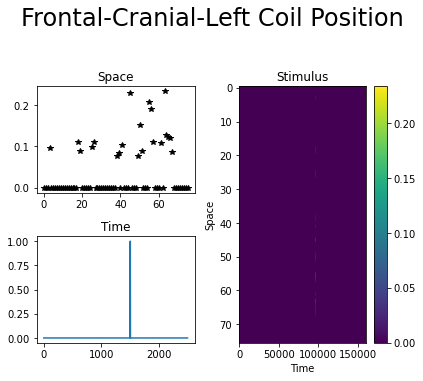

In [8]:
# Choose stimulus shape from "SinglePulse", "rTMS", "iTBS"
stim = get_stimulus(weighting, white_matter, duration=2.5e3, type="SinglePulse")
plot_stimulus(stim, fig8_coil.pos_list[ind], type="rTMS")

### Define monitors

In [14]:
# Choose monitor/s from "raw", "tavg", "savg", "eeg" and "bold"
monitors_needed = ["eeg"] 
all_mons = get_monitors(monitors_needed)

### Define the simulator

In [15]:
#resting state simulation
rs_sim = simulator.Simulator(model=neuron_model,
                          connectivity=white_matter,
                          coupling=white_matter_coupling,
                          integrator=heunint,
#                           surface=default_cortex
                          monitors=all_mons,
                         )
rs_sim.configure()

   INFO  Projection configured gain shape (65, 76)


,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 503f799e-310c-488f-b68f-08f1958d6e77
coupling,Difference gid: 51bf61f1-9c5a-423e-a1df-ea7dbe5a679a
gid,UUID('95c942f8-80b2-42a0-afa9-e16d3525ffee')
initial_conditions,None
integrator,HeunStochastic gid: d534a409-4e5a-4759-b88e-8769ea012207
model,Generic2dOscillator gid: f8e08853-a628-403d-8ae1-ab6a6b7d712f
monitors,[]
simulation_length,1000.0


In [16]:
#tms simulation
tms_sim = simulator.Simulator(model=neuron_model,
                          connectivity=white_matter,
                          coupling=white_matter_coupling,
                          integrator=heunint,
#                           surface=default_cortex,   
                          monitors=all_mons,
                          stimulus=stim, 
                         )
tms_sim.configure()

   INFO  Projection configured gain shape (65, 76)


,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 503f799e-310c-488f-b68f-08f1958d6e77
coupling,Difference gid: 51bf61f1-9c5a-423e-a1df-ea7dbe5a679a
gid,UUID('12e4fac2-a009-4fd2-8722-a186216d378d')
initial_conditions,None
integrator,HeunStochastic gid: d534a409-4e5a-4759-b88e-8769ea012207
model,Generic2dOscillator gid: f8e08853-a628-403d-8ae1-ab6a6b7d712f
monitors,[]
simulation_length,1000.0


### Run simulation

In [17]:
duration = 2.5e3 
rs_data = run_simulation(rs_sim, duration, monitors_needed)
tms_data = run_simulation(tms_sim, duration, monitors_needed)

The simulation took 25.4s to run
The simulation took 26.8s to run


### Visualisation

Resting state simulation:


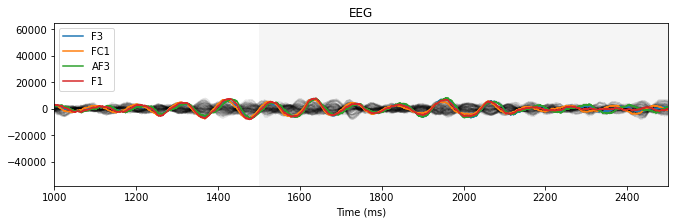

TMS simulation:


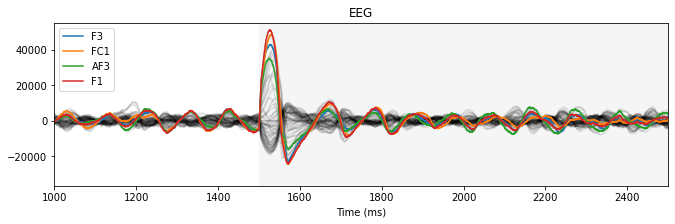

In [20]:
EOI=[3, 41, 42, 58] # electrodes of interest
EOI_labels=all_mons[0].sensors.labels[EOI]

print('Resting state simulation:')
plot_monitor_data(rs_data, monitors_needed, duration, EOI, EOI_labels)

print('TMS simulation:')
plot_monitor_data(tms_data, monitors_needed, duration, EOI, EOI_labels)

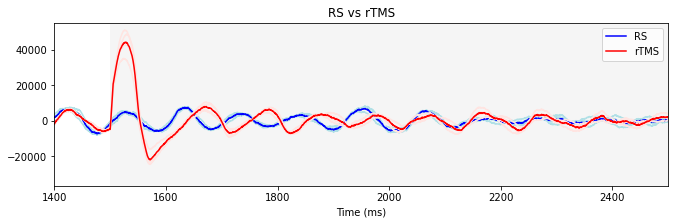

In [21]:
# RS vs TMS
plot_eeg_comparison(rs_data['eeg'], tms_data['eeg'], duration, 'RS vs rTMS', ['RS', 'rTMS'])

### Extract TEPs and visualise them

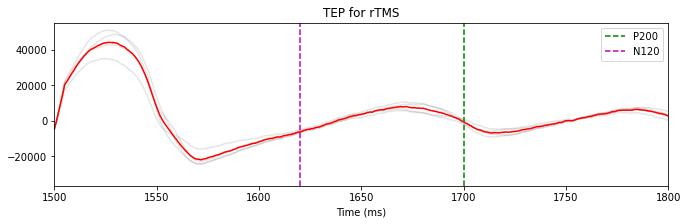

In [22]:
plot_TEP(tms_data['eeg'], stimulus='rTMS')

## DISCLAIMER: everything from here is broken
WIP: still needs to be cleaned

In order to get similar plots as in (Spiegler et al., 2016), we need to define a function that visualizes the propagation on the template brain (taken from https://nbviewer.jupyter.org/urls/s3.amazonaws.com/replicating_spiegler2016/replicating_spiegler2016__html_nb.ipynb).

Another intro to visualization of TVB results with matplotlib can be seen here: https://johngriffiths.github.io/LabNotebook/mpl-surface-viz.html 

In [29]:
#Visualization
def plot_surface_mpl(vtx,tri,data=None,rm=None,reorient='tvb',view='superior',
                     shaded=False,ax=None,figsize=(6,4), title=None,
                     lthr=None,uthr=None, nz_thr = 1E-20,
                     shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': None, 'vmax': None}):
                        
  r"""Plot surfaces, surface patterns, and region patterns with matplotlib
    
  This is a general-use function for neuroimaging surface-based data, and 
  does not necessarily require construction of or interaction with tvb 
  datatypes. 

  See also:  plot_surface_mpl_mv



  Parameters
  ----------
  
  vtx           : N vertices x 3 array of surface vertex xyz coordinates 

  tri           : N faces x 3 array of surface faces

  data          : array of numbers to colour surface with. Can be either 
                  a pattern across surface vertices (N vertices x 1 array),
                  or a pattern across the surface's region mapping 
                  (N regions x 1 array), in which case the region mapping 
                  bust also be given as an argument. 
                  
  rm            : region mapping - N vertices x 1 array with (up to) N 
                  regions unique values; each element specifies which 
                  region the corresponding surface vertex is mapped to 

  reorient      : modify the vertex coordinate frame and/or orientation 
                  so that the same default rotations can subsequently be 
                  used for image views. The standard coordinate frame is 
                  xyz; i.e. first,second,third axis = left-right, 
                  front-back, and up-down, respectively. The standard 
                  starting orientation is axial view; i.e. looking down on
                  the brain in the x-y plane.
                  
                  Options: 

                    tvb (default)   : swaps the first 2 axes and applies a rotation
                                              
                    fs              : for the standard freesurfer (RAS) orientation; 
                                      e.g. fsaverage lh.orig. 
                                      No transformations needed for this; so is 
                                      gives same result as reorient=None

  view          : specify viewing angle. 
  
                  This can be done in one of two ways: by specifying a string 
                  corresponding to a standard viewing angle, or by providing 
                  a tuple or list of tuples detailing exact rotations to apply 
                  around each axis. 
                  
                  Standard view options are:
    
                  lh_lat / lh_med / rh_lat / rh_med / 
                  superior / inferior / posterior / anterior

                  (Note: if the surface contains both hemispheres, then medial 
                   surfaces will not be visible, so e.g. 'rh_med' will look the 
                   same as 'lh_lat')
                   
                  Arbitrary rotations can be specied by a tuple or a list of 
                  tuples, each with two elements, the first defining the axis 
                  to rotate around [0,1,2], the second specifying the angle in 
                  degrees. When a list is given the rotations are applied 
                  sequentially in the order given. 
                  
                  Example: rotations = [(0,45),(1,-45)] applies 45 degrees 
                  rotation around the first axis, followed by 45 degrees rotate 
                  around the second axis. 

  lthr/uthr     : lower/upper thresholds - set to zero any datapoints below / 
                  above these values
  
  nz_thr        : near-zero threshold - set to zero all datapoints with absolute 
                  values smaller than this number. Default is a very small 
                  number (1E-20), which unless your data has very small numbers, 
                  will only mask out actual zeros. 

  shade_kwargs  : dictionary specifiying shading options

                  Most relevant options (see matplotlib 'tripcolor' for full details):
                  
                    - 'shading'        (either 'gourand' or omit; 
                                        default is 'flat')
                    - 'edgecolors'     'k' = black is probably best
                    - 'linewidth'      0.1 works well; note that the visual 
                                       effect of this will depend on both the 
                                       surface density and the figure size 
                    - 'cmap'           colormap
                    - 'vmin'/'vmax'    scale colormap to these values
                    - 'alpha'          surface opacity
                  
  ax            : figure axis
  
  figsize       : figure size (ignore if ax provided)
  
  title         : text string to place above figure
  
  
  
                  
  Usage
  -----
       

  Basic freesurfer example:

  import nibabel as nib
  vtx,tri = nib.freesurfer.read_geometry('subjects/fsaverage/surf/lh.orig')
  plot_surface_mpl(vtx,tri,view='lh_lat',reorient='fs')



  Basic tvb example:
  
  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat,view='inferior',title='inferior')

  fig, ax = plt.subplots()
  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat, view=[(0,-90),(1,55)],ax=ax,
                   title='lh angle',shade_kwargs={'shading': 'gouraud', 'cmap': 'rainbow'})

   
  """
    
  # Copy things to make sure we don't modify things 
  # in the namespace inadvertently. 
    
  vtx,tri = vtx.copy(),tri.copy()
  if data is not None: data = data.copy()

  # 1. Set the viewing angle 
  
  if reorient == 'tvb':
    # The tvb default brain has coordinates in the order 
    # yxz for some reason. So first change that:   
    vtx = np.array([vtx[:,1],vtx[:,0],vtx[:,2]]).T.copy()
    
    # Also need to reflect in the x axis
    vtx[:,0]*=-1

  # (reorient == 'fs' is same as reorient=None; so not strictly needed
  #  but is included for clarity)
   


  # ...get rotations for standard view options
    
  if   view == 'lh_lat'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'lh_med'    : rots =  [(0,-90),(1,-90) ] 
  elif view == 'rh_lat'    : rots =  [(0,-90),(1,-90) ]
  elif view == 'rh_med'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'superior'  : rots =   None
  elif view == 'inferior'  : rots =   (1,180)
  elif view == 'anterior'  : rots =   (0,-90)
  elif view == 'posterior' : rots =  [(0, -90),(1,180)]
  elif (type(view) == tuple) or (type(view) == list): rots = view 

  # (rh_lat is the default 'view' argument because no rotations are 
  #  for that one; so if no view is specified when the function is called, 
  #  the 'rh_lat' option is chose here and the surface is shown 'as is' 
                            
                            
  # ...apply rotations                          
     
  if rots is None: rotmat = np.eye(3)
  else:            rotmat = get_combined_rotation_matrix(rots)
  vtx = np.dot(vtx,rotmat)

                                    
      
  # 2. Sort out the data
                                    
                                    
  # ...if no data is given, plot a vector of 1s. 
  #    if using region data, create corresponding surface vector 
  if data is None: 
    data = np.ones(vtx.shape[0]) 
  elif data.shape[0] != vtx.shape[0]: 
    data = np.array([data[r] for r in rm])
    
  # ...apply thresholds
  if uthr: data *= (data < uthr)
  if lthr: data *= (data > lthr)
  data *= (np.abs(data) > nz_thr)

                                    
  # 3. Create the surface triangulation object 
  
  x,y,z = vtx.T
  tx,ty,tz = vtx[tri].mean(axis=1).T
  tr = Triangulation(x,y,tri[np.argsort(tz)])
                
  # 4. Make the figure 

  if ax is None: fig, ax = plt.subplots(figsize=figsize)  
  
  #if shade = 'gouraud': shade_opts['shade'] = 
  tc = ax.tripcolor(tr, np.squeeze(data), **shade_kwargs)
                        
  ax.set_aspect('equal')
  ax.axis('off')
    
  if title is not None: ax.set_title(title)
            

def get_combined_rotation_matrix(rotations):
  '''Return a combined rotation matrix from a dictionary of rotations around 
     the x,y,or z axes'''
  rotmat = np.eye(3)
    
  if type(rotations) is tuple: rotations = [rotations] 
  for r in rotations:
    newrot = get_rotation_matrix(r[0],r[1])
    rotmat = np.dot(rotmat,newrot)
  return rotmat


def get_rotation_matrix(rotation_axis, deg):

  '''Return rotation matrix in the x,y,or z plane'''



  # (note make deg minus to change from anticlockwise to clockwise rotation)
  th = -deg * (pi/180) # convert degrees to radians

  if rotation_axis == 0:
    return np.array( [[    1,         0,         0    ],
                      [    0,      cos(th),   -sin(th)],
                      [    0,      sin(th),    cos(th)]])
  elif rotation_axis ==1:
    return np.array( [[   cos(th),    0,        sin(th)],
                      [    0,         1,          0    ],
                      [  -sin(th),    0,        cos(th)]])
  elif rotation_axis ==2:
    return np.array([[   cos(th),  -sin(th),     0    ],
                     [    sin(th),   cos(th),     0   ],
                     [     0,         0,          1   ]])

In [30]:
from matplotlib.tri import Triangulation

def plot_activity_on_brain(time, MON, time_stamps, title=''):
    
    vtx,tri,rm = default_cortex.vertices,default_cortex.triangles,default_cortex.region_mapping # CHANGE VARIABLE NAMES?
    fig, ax = plt.subplots(ncols=10, nrows=2,figsize=(15,3))
    cmap = cm.Reds #JAN SAID cmap IS A DEFAULT VARIABLE, MAYBE NAME ERROR
    cmap.set_under(color='w')

    kws = {'edgecolors': 'k', 'vmin': 0.1, 'cmap': cmap, 
           'vmax': 0.6, 'alpha': None, 'linewidth': 0.01} # MAYBE SCALING IS THE PROBLEM? SECOND CALL # OUTLIERS CHANGING THIS?

    for t_it,t in enumerate(time_stamps):

        dat = np.absolute(MON[t, 0, :, 0])

        plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=rm,ax=ax[0][t_it], # VTX = VTX IS NOT DESIRABLE
                       shade_kwargs=kws,
                       view='lh_lat')

        plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=rm,ax=ax[1][t_it],
                       shade_kwargs=kws,
                       view='rh_lat')

        ax[0][t_it].set_title('t=%1.1fms' %time[t])
    fig.suptitle(title, fontsize=15)

/home/anujanegi/TVB_Distribution/tvb_data/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  


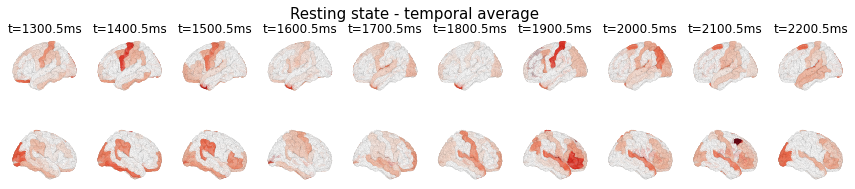

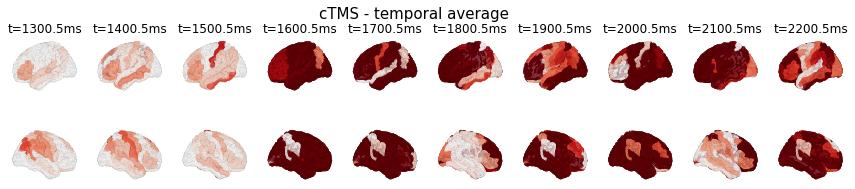

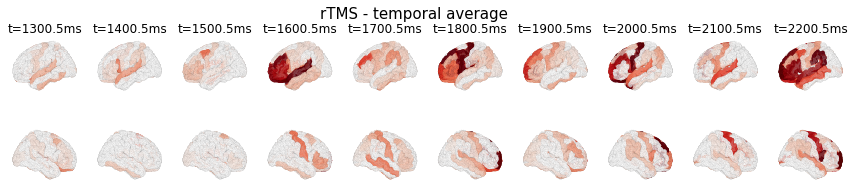

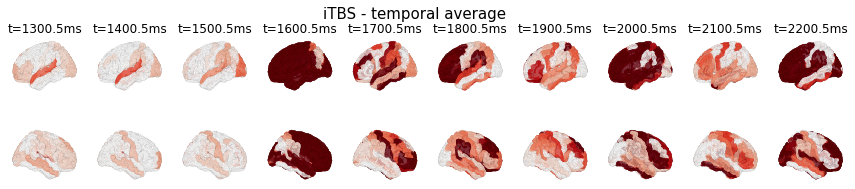

In [31]:
time_stamps = [1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200]
plot_activity_on_brain(tavg_time, TAVG_RS, time_stamps, "Resting state - temporal average")
plot_activity_on_brain(tavg_time, TAVG_TMS, time_stamps, "cTMS - temporal average")
plot_activity_on_brain(tavg_time, TAVG_RTMS, time_stamps, "rTMS - temporal average")
plot_activity_on_brain(tavg_time, TAVG_ITBS, time_stamps, "iTBS - temporal average")

/home/anujanegi/TVB_Distribution/tvb_data/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  


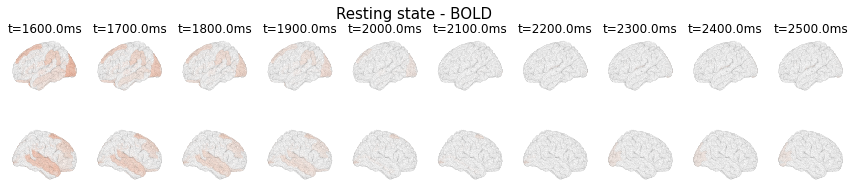

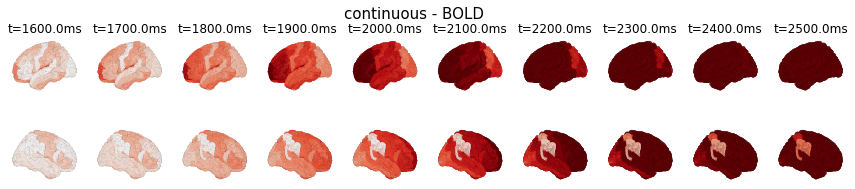

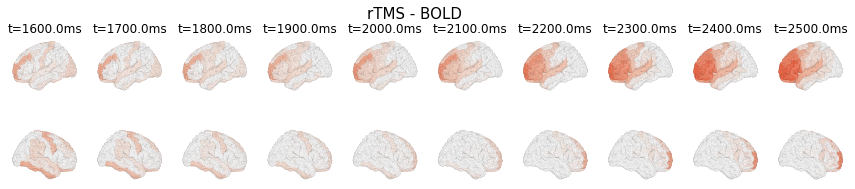

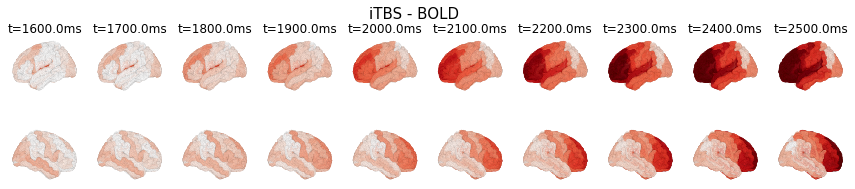

In [32]:
time_stamps = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24] # TODO: only till 1600ms
plot_activity_on_brain(bold_time, BOLD_RS, time_stamps, "Resting state - BOLD")
plot_activity_on_brain(bold_time, BOLD_TMS, time_stamps, "continuous - BOLD")
plot_activity_on_brain(bold_time, BOLD_RTMS, time_stamps, "rTMS - BOLD")
plot_activity_on_brain(bold_time, BOLD_ITBS, time_stamps, "iTBS - BOLD")